# Overview

After my, let's say, [_spontaneous_ attempt](https://www.kaggle.com/thiagodsd/nyc-taxi-trip-duration) to find out the duration of taxi trips in New York - which occurs to be my submission ever -, I devote this notebook to study alternative regression approaches and techniques. 

Again, the purpose of this notebook is to study, therefore there are none original idea/solution/approach below, just reproductions and minor adaptations from other sources. Still I'd glad if it helps somebody somewhat.

- - -

References first to give an overview:

1. [Outlier Detection Practice: uni/multivariate | Kaggle](https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate) - since data cleaning was a step which stuck me a little. Thanks to [Kevin Arvai](https://www.kaggle.com/kevinarvai).

2. [7 Regression Types and Techniques in Data Science](https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/)
    - [Linear, Ridge and Lasso Regression comprehensive guide for beginners](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)
    - [Neural Network Model for House Prices (Keras) | Kaggle](https://www.kaggle.com/diegosiebra/neural-network-model-for-house-prices-keras) - thanks to [Diego Siebra Ferreira](https://www.kaggle.com/diegosiebra).
    - [Regression, Blending and Stacking V.02 | Kaggle](https://www.kaggle.com/zugariy/regression-blending-and-stacking-v-02) - thanks to [ZugariY](https://www.kaggle.com/zugariy).

3. [Blending of 6 Models (Top 10%) | Kaggle](https://www.kaggle.com/sandeepkumar121995/blending-of-6-models-top-10) - thanks to [Sandeep Kumar](https://www.kaggle.com/sandeepkumar121995).

```
[From EDA to the Top (LB 0.367) | Kaggle](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)
[Predicting House Prices || Regression Techniques | Kaggle](https://www.kaggle.com/janiobachmann/predicting-house-prices-regression-techniques)
[EDA, Introduction to Ensemble Regression | Kaggle](https://www.kaggle.com/yassineghouzam/eda-introduction-to-ensemble-regression)
```

- - -


Checking files:

In [0]:
#from google.colab import files
#_json = files.upload()

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

#!mkdir ~/data
#!mkdir ~/data/nyc-taxi-trip-duration/
#!kaggle competitions download -c nyc-taxi-trip-duration -p ~/data/nyc-taxi-trip-duration/

# !unzip /root/data/nyc-taxi-trip-duration/sample_submission.zip -d /root/data/nyc-taxi-trip-duration/
# !unzip /root/data/nyc-taxi-trip-duration/train.zip -d /root/data/nyc-taxi-trip-duration/
# !unzip /root/data/nyc-taxi-trip-duration/test.zip -d /root/data/nyc-taxi-trip-duration/

In [2]:
import numpy  as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/root/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/data/nyc-taxi-trip-duration/sample_submission.zip
/root/data/nyc-taxi-trip-duration/db_predict.p
/root/data/nyc-taxi-trip-duration/test.csv
/root/data/nyc-taxi-trip-duration/sample_submission.csv
/root/data/nyc-taxi-trip-duration/train.zip
/root/data/nyc-taxi-trip-duration/kmeans_predict.p
/root/data/nyc-taxi-trip-duration/test.zip
/root/data/nyc-taxi-trip-duration/train.csv


Summoning some libs:

In [0]:
import datetime
import warnings
import pickle
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

from sklearn.cluster      import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_log_error


from IPython.display import display, FileLink

#

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]
np.random.seed(1642)

defining some functions:

In [0]:
def var_cleaner(s):
    """
    ('var1, var2, ..., varN') -> None
    """
    trash = list()
    miss  = list()
    for v in s.replace(' ', '').split(','):
        if v in globals():
            del globals()[v]
            trash.append(v)
        else:
            miss.append(v)
    print('- DELETED:     {}'.format( ', '.join(trash) ))
    print('- NOT DEFINED: {}'.format( ', '.join(miss) ))

In [0]:
from math import sin, cos, sqrt, atan2, radians
def lat_lon_converter(lat1, lon1, lat2, lon2, unit):
    """
    ref: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """
    try:
        R = 6373.0
        dlon = radians(lon2) - radians(lon1)
        dlat = radians(lat2) - radians(lat1)
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c

        if unit == 'm':
            return distance * 10e3
        elif unit == 'km':
            return distance
    except ValueError:
        return np.nan

In [0]:
def dbscan_predict(model, X):
    """
    ref: https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan
    """
    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]   # NumPy broadcasting
        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance
        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

Loading data:

In [7]:
df_train = pd.read_csv('/root/data/nyc-taxi-trip-duration/train.csv')
df_test  = pd.read_csv('/root/data/nyc-taxi-trip-duration/test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

display( df_train.head() )
display( df_test.head() )

train:  (1458644, 11)
test:   (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [40]:
_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])

display(_FEATURES)

{'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'store_and_fwd_flag',
 'vendor_id'}

In [0]:
train = df_train[_FEATURES]
test  = df_test[_FEATURES]

In [42]:
train.describe().apply( lambda s: s.apply( lambda x: format(x, '.3f') ) )

,dropoff_latitude,pickup_longitude,passenger_count,vendor_id,dropoff_longitude,pickup_latitude
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,40.752,-73.973,1.665,1.535,-73.973,40.751
std,0.036,0.071,1.314,0.499,0.071,0.033
min,32.181,-121.933,0.000,1.000,-121.933,34.360
25%,40.736,-73.992,1.000,1.000,-73.991,40.737
50%,40.755,-73.982,1.000,2.000,-73.980,40.754
75%,40.770,-73.967,2.000,2.000,-73.963,40.768
max,43.921,-61.336,9.000,2.000,-61.336,51.881


In [0]:
sample = train[['dropoff_latitude', 'dropoff_longitude']].sample(10000)

# Outlier Detection

![](https://2b1ohome.files.wordpress.com/2019/10/icon_outlier-4.png)

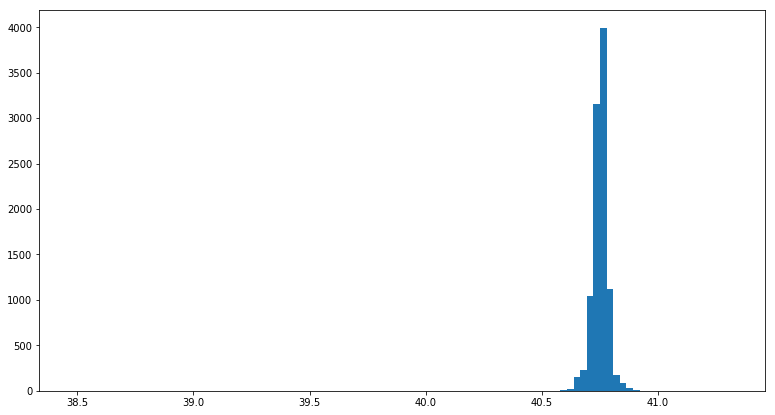

In [44]:
plt.hist(sample['dropoff_latitude'], bins=100);

## Univariate

### Standard Deviation & Interquartile Range Method

> A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

In [0]:
def out_std(data, n_std=3.0, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    mean, std    = data.mean(), data.std()
    cutoff       = std * n_std
    lower, upper = mean - cutoff, mean + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

def out_iqr(data, k=1.5, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    q25, q75     = np.percentile(data, 25), np.percentile(data, 75)
    iqr          = q75 - q25
    cutoff       = iqr * k
    lower, upper = q25 - cutoff, q75 + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

In [46]:
out_mask_std = out_std(sample['dropoff_latitude'], n_std=3.0)
display( np.unique(out_mask_std, return_counts=True) )

out_mask_iqr = out_iqr(sample['dropoff_latitude'], k=1.5)
display( np.unique(out_mask_iqr, return_counts=True) )

(array([False,  True]), array([9946,   54]))

(array([False,  True]), array([9489,  511]))

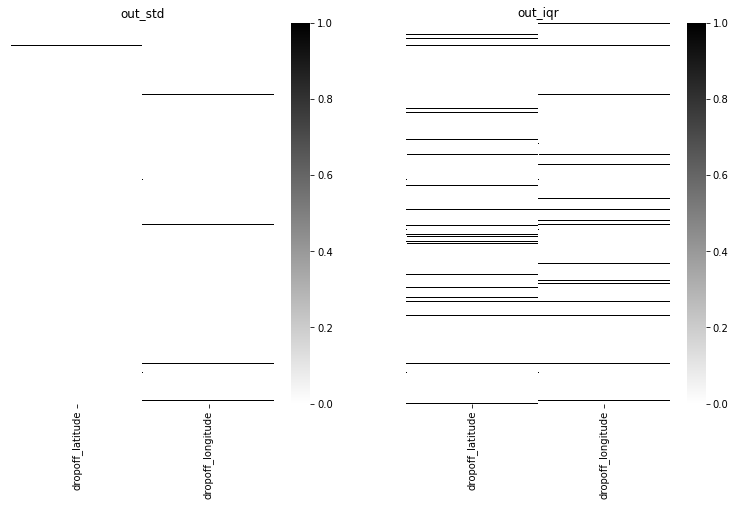

In [47]:
_filter = sample.dtypes[~(sample.dtypes.isin([ np.dtype('object'),  np.dtype('<M8[ns]')]))].index

out_mask_std = sample[_filter].apply(out_std, n_std=3.0)
out_mask_iqr = sample[_filter].apply(out_iqr, k=1.5)

f, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1)

sns.heatmap(out_mask_std, cmap='binary', ax=ax1)
sns.heatmap(out_mask_iqr, cmap='binary', ax=ax2)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.axes.get_yaxis().set_visible(False)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.axes.get_yaxis().set_visible(False)

ax1.set_title(r'out_std')
ax2.set_title(r'out_iqr');

### Isolation Forest

In [48]:
from sklearn.ensemble import IsolationForest

out_if = IsolationForest(n_estimators=100)
out_if.fit(sample['dropoff_latitude'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

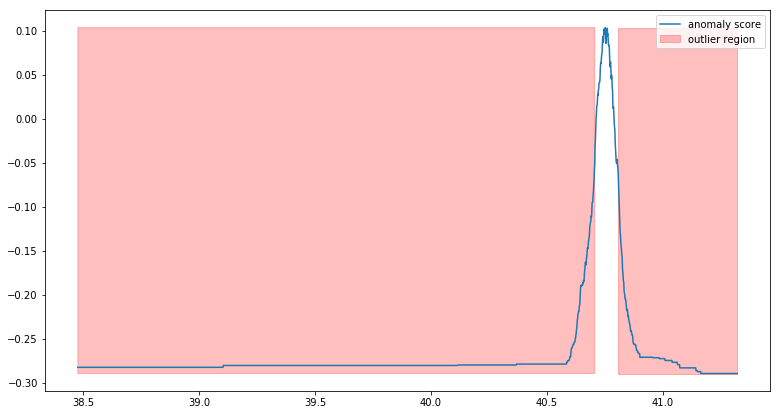

In [49]:
xx = np.linspace(sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max(), int(sample.shape[0]/5.0)).reshape(-1, 1)

anomaly_score = out_if.decision_function(xx)
out_bounds    = out_if.predict(xx)

plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score),  np.max(anomaly_score), where=(out_bounds==-1), alpha=.25, color='r', label='outlier region')

plt.legend();

## Multivariate

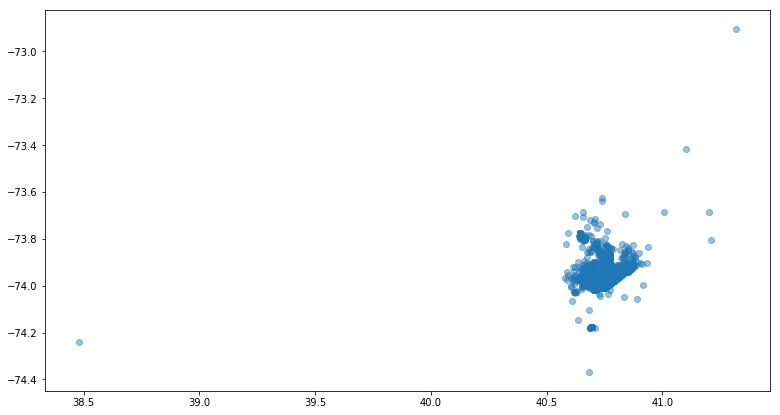

In [50]:
plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);

### Isolation Forest

In [51]:
from sklearn.ensemble import IsolationForest

out_if = IsolationForest()
out_if.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

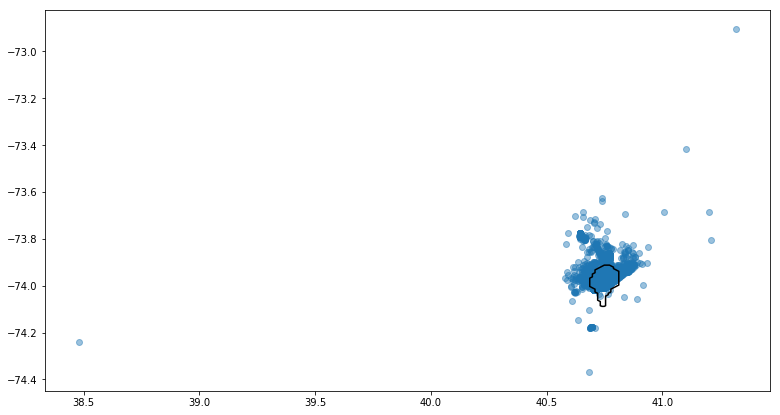

In [52]:
xx_bounds = [sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max()]
yy_bounds = [sample['dropoff_longitude'].min(), sample['dropoff_longitude'].max()]

xx, yy = np.meshgrid(np.linspace(min(xx_bounds), max(xx_bounds), 250),
                    np.linspace(min(yy_bounds), max(yy_bounds), 250))

zz = out_if.predict(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

### Elliptic Envelope

> Outlier detection from covariance estimation may break or not perform well in high-dimensional settings. In particular, one will always take care to work with n_samples > n_features ** 2.

([ref](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope))

In [53]:
from sklearn.covariance import EllipticEnvelope

out_elp = EllipticEnvelope()
out_elp.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

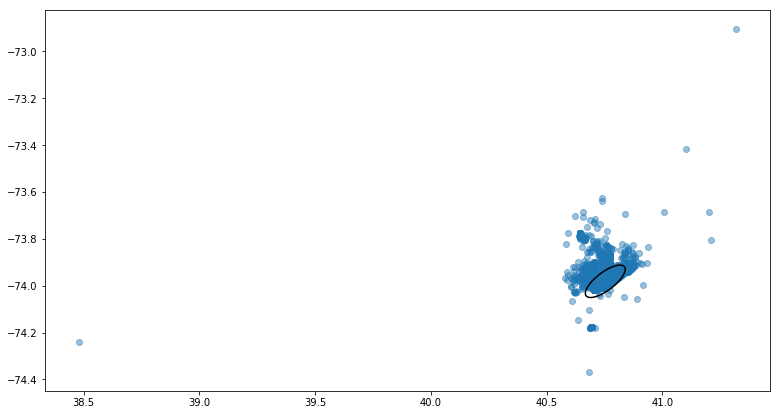

In [54]:
zz = out_elp.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

### DBSCAN

In [55]:
from sklearn.preprocessing  import StandardScaler
from sklearn.cluster        import DBSCAN

X      = StandardScaler().fit_transform(sample.values)
out_db = DBSCAN(eps=0.75, min_samples=10).fit(X)
labels = out_db.labels_

np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([  32, 9948,   20]))

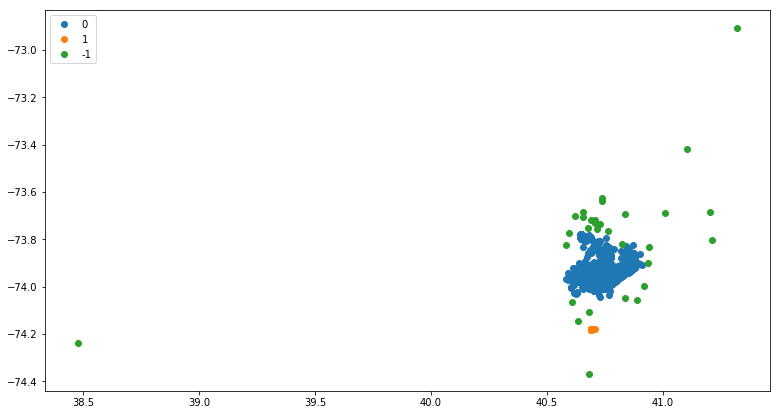

In [56]:
unique_labels = set(labels)

for label in unique_labels:
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(sample['dropoff_latitude'][sample_mask], sample['dropoff_longitude'][sample_mask], 'o', label=label);
plt.legend();

### Local Outlier Factor

>  The advantage of sklearn.neighbors.LocalOutlierFactor over the other estimators is shown for the third data set, where the two modes have different densities. This advantage is explained by the local aspect of LOF, meaning that it only compares the score of abnormality of one sample with the scores of its neighbors.

In [57]:
from sklearn.neighbors import LocalOutlierFactor

out_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
out_lof.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=10, novelty=True, p=2)

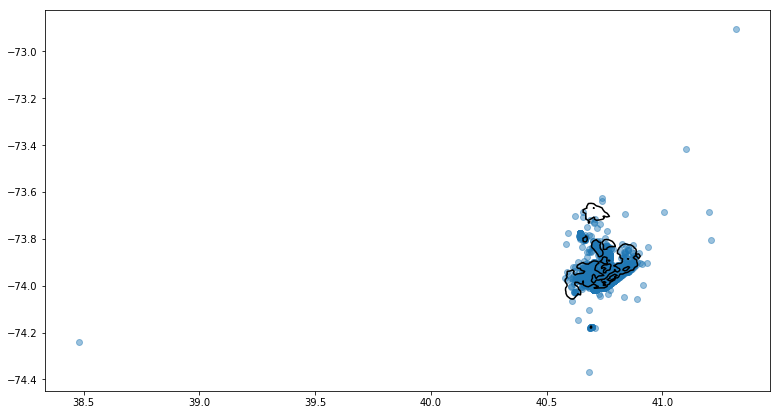

In [58]:
zz = out_lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

# Feature Engineering & Data Imputing

![](https://2b1ohome.files.wordpress.com/2019/10/icon_cleaning-3.png)

Apparently the _NYC Taxi Trip Duration_ dataset doesn't demand complex imputation techniques, so I'll replicate data preparation steps from my original notebook.

Prophylactic reloadings.

In [7]:
df_train = pd.read_csv('/root/data/nyc-taxi-trip-duration/train.csv')
df_test  = pd.read_csv('/root/data/nyc-taxi-trip-duration/test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

# display( df_train.head() )
# display( df_test.head() )

_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])
#display(_FEATURES)

train = df_train[_FEATURES]
test  = df_test[_FEATURES]

train:  (1458644, 11)
test:   (625134, 9)


Temporal features

In [0]:
train['pickup_dt'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
train = train.drop(columns=['pickup_datetime'])

train['pick_minute']     = train['pickup_dt'].dt.minute
train['pick_hour']       = train['pickup_dt'].dt.hour
train['pick_day']        = train['pickup_dt'].dt.day
train['pick_month']      = train['pickup_dt'].dt.month
train['pick_year']       = train['pickup_dt'].dt.year
train['pick_quarter']    = train['pickup_dt'].dt.quarter
train['pick_weekofyear'] = train['pickup_dt'].dt.weekofyear

Spatial features

In [0]:
train['lon_lat_manhattan']    = abs(train['dropoff_longitude']-train['pickup_longitude']) + abs(train['dropoff_latitude']-train['pickup_latitude'])
train['dist_manhattan_meter'] = train.apply( lambda x: lat_lon_converter(x['pickup_latitude'], 
                                                                         x['pickup_longitude'],
                                                                         x['dropoff_latitude'], 
                                                                         x['dropoff_longitude'],
                                                                         'm'), axis=1 )

Clustering location

In [0]:
sample = train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].sample(10000, random_state=37)
X      = StandardScaler().fit_transform(sample.values)

In [0]:
db     = DBSCAN(eps=0.75, min_samples=10).fit(X)
kmeans = KMeans(n_clusters=5, random_state=37).fit(X)

In [0]:
# train['db_predict']     = dbscan_predict(db, StandardScaler().fit_transform(train[['pickup_latitude', 
#                                                                                    'pickup_longitude', 
#                                                                                    'dropoff_latitude', 
#                                                                                    'dropoff_longitude']].values))
# train['kmeans_predict'] = kmeans.predict(StandardScaler().fit_transform(train[['pickup_latitude', 
#                                                                                'pickup_longitude', 
#                                                                                'dropoff_latitude', 
#                                                                                'dropoff_longitude']].values))

# pickle.dump(train[['db_predict']], open('/root/data/nyc-taxi-trip-duration/db_predict.p', 'wb'))
# pickle.dump(train[['kmeans_predict']], open('/root/data/nyc-taxi-trip-duration/kmeans_predict.p', 'wb'))
train['db_predict']   = pickle.load(open('/root/data/nyc-taxi-trip-duration/db_predict.p', 'rb'))
train['kmeans_predict']   = pickle.load(open('/root/data/nyc-taxi-trip-duration/kmeans_predict.p', 'rb'))

Preparing to regression

In [13]:
_FILTERS = {
            'int'   : [ [None], [np.dtype('int64')] ],
            'float' : [ [None], [np.dtype('float64')] ],
            'cat'   : [ [None], [np.dtype('object')] ],
            'date'  : [ [None], [np.dtype('<M8[ns]')] ]
           }

for k in _FILTERS:
    _FILTERS[k][0] = set(train.dtypes[ train.dtypes.isin(_FILTERS[k][1]) ].index.to_list())
    print( k, _FILTERS[k][0] )


int {'pick_month', 'pick_quarter', 'pick_year', 'passenger_count', 'vendor_id', 'pick_weekofyear', 'db_predict', 'pick_minute', 'pick_day', 'pick_hour'}
float {'dropoff_longitude', 'dist_manhattan_meter', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'lon_lat_manhattan'}
cat {'store_and_fwd_flag'}
date {'pickup_dt'}


In [0]:
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

int_pipeline   = Pipeline([ ('imputer', SimpleImputer(strategy="constant", fill_value=-1)) ])
float_pipeline = Pipeline([ 
                          ('imputer'   , SimpleImputer(strategy="median")),
                          ('std_scaler', StandardScaler())
                          ])

full_pipeline = ColumnTransformer([
                                  ('int'  , int_pipeline,    list(_FILTERS['int'][0]) ),
                                  ('float', float_pipeline,  list(_FILTERS['float'][0]) ) ,
                                  ('cat'  , OneHotEncoder(), list(_FILTERS['cat'][0]) )
                                  ])

- - -

In [15]:
train_x = full_pipeline.fit_transform( train[set.union(*[_FILTERS['int'][0], _FILTERS['float'][0], _FILTERS['cat'][0]])] )
train_y = df_train[['trip_duration']]

train_y['trip_duration'] = train_y['trip_duration'].mask(train_y['trip_duration'].lt(0), 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(train_x, train_y, 
                                                          test_size    = 0.2, 
                                                          random_state = 37)

gc.collect()

10

# Regression Models

Removing categorical features.

In [0]:
full_pipeline = ColumnTransformer([
                                  ('int'  , int_pipeline,    list(_FILTERS['int'][0]) ),
                                  ('float', float_pipeline,  list(_FILTERS['float'][0]) ) ,
                                  # ('cat'  , OneHotEncoder(), list(_FILTERS['cat'][0]) )
                                  ])

train_x = full_pipeline.fit_transform( train[set.union(*[_FILTERS['int'][0], _FILTERS['float'][0]])] )

train_y = df_train[['trip_duration']]
train_y['trip_duration'] = train_y['trip_duration'].mask(train_y['trip_duration'].lt(0), 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(train_x, train_y, test_size = 0.2, random_state = 37)

## Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train, y_train)

y_pred_train   = linreg.predict(X_train)
y_pred_holdout = linreg.predict(X_holdout)

display( mean_absolute_error( y_train , y_pred_train ) )
display( mean_absolute_error( y_holdout , y_pred_holdout ) )

465.37437547099347

453.415818640902

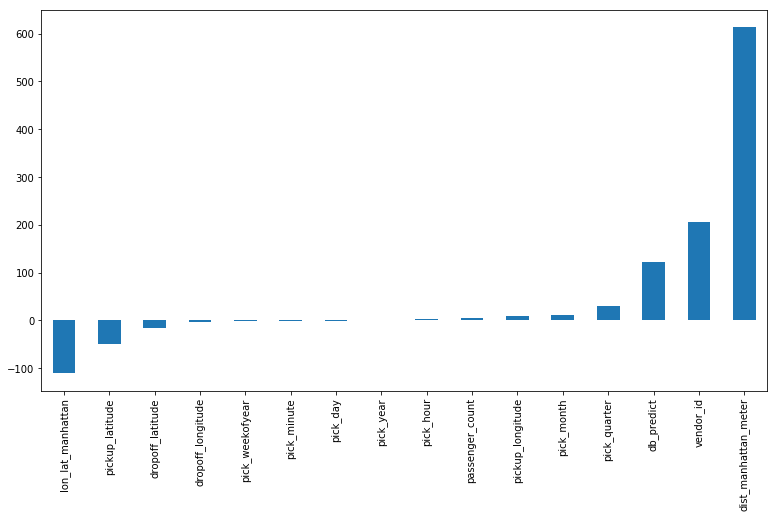

In [40]:
def get_feature_names(columnTransformer):
    """
    ref: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api
    """
    output_features = []

    for transformers in columnTransformer.transformers_:

        if transformers[0]!='remainder':
            pipeline = transformers[1]
            features = transformers[2]

            for i in pipeline:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

pd.Series( linreg.coef_[0], get_feature_names(full_pipeline) ).sort_values().plot(kind='bar')

## Polynomial Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures

d = 2
polyreg = PolynomialFeatures(degree=d)
x_poly  = polyreg.fit_transform(X_train)

linreg_p  = LinearRegression(fit_intercept=False)
linreg_p.fit(x_poly, y_train)

# accuracy evaluation

y_pred_train   = linreg_p.predict(x_poly)
del x_poly; gc.collect()
x_poly         = polyreg.fit_transform(X_holdout)
y_pred_holdout = linreg_p.predict(x_poly)
del x_poly;gc.collect()

print('\n degree={}'.format(d))
display( mean_absolute_error( y_train , y_pred_train ) )
display( mean_absolute_error( y_holdout , y_pred_holdout ) )


 degree=2


434.43643833145865

425.1694239555514

Note: $\frac{n(n+1)}{2}$ features due to `PolynomialFeatures(n)` prevents a nice coefficients plot.

## Ridge Regression

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_cv   = GridSearchCV(Ridge(fit_intercept=False), {'alpha': [10e-10, 10e-8, 10e-4, 10e-2, 1, 10]}, scoring='neg_mean_absolute_error', cv=5)
ridge_cv.fit(X_train, y_train);

In [50]:
ridreg = Ridge( alpha=ridge_cv.best_params_['alpha'], fit_intercept=False )
ridreg.fit(X_train, y_train)

y_pred_train   = ridreg.predict(X_train)
y_pred_holdout = ridreg.predict(X_holdout)

display( mean_absolute_error( y_train , y_pred_train ) )
display( mean_absolute_error( y_holdout , y_pred_holdout ) )

465.3743754709881

453.4158186408967

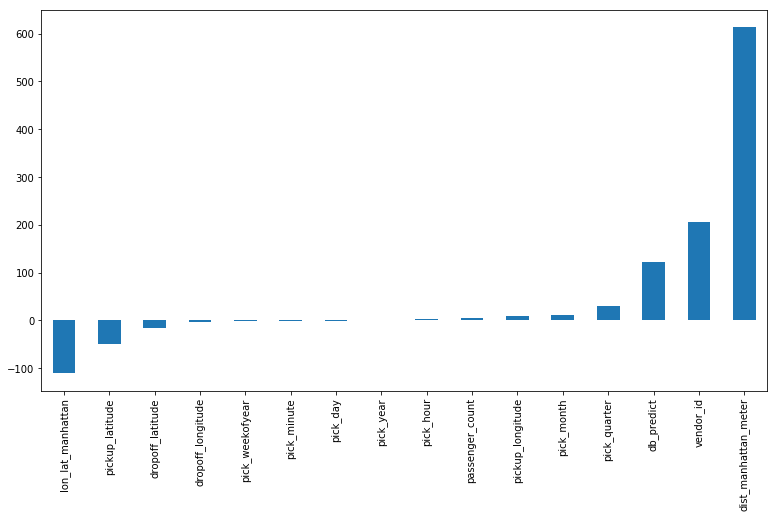

In [52]:
pd.Series( ridreg.coef_[0], get_feature_names(full_pipeline) ).sort_values().plot(kind='bar')

## Lasso Regression

In [0]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_cv   = GridSearchCV(Lasso(fit_intercept=False), {'alpha': [10e-4, 1, 10]}, scoring='neg_mean_absolute_error', cv=3)
lasso_cv.fit(X_train, y_train);

In [58]:
lassoreg = Lasso( alpha=lasso_cv.best_params_['alpha'], fit_intercept=False )
lassoreg.fit(X_train, y_train)

y_pred_train   = lassoreg.predict(X_train)
y_pred_holdout = lassoreg.predict(X_holdout)

display( mean_absolute_error( y_train , y_pred_train ) )
display( mean_absolute_error( y_holdout , y_pred_holdout ) )

465.37503071781344

453.41647078802737

# Helper

In [0]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [25]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train: 473.0 MiB
                         train: 286.6 MiB
                       train_x: 178.1 MiB
                       df_test: 152.6 MiB
                       X_train: 142.4 MiB
                          test: 113.3 MiB
                     X_holdout: 35.6 MiB
                       y_train: 17.8 MiB
                       train_y: 11.1 MiB
                  y_pred_train:  8.9 MiB


In [24]:
gc.collect()

392

- - -